In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

import time
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics

# NLP
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB # NLP classification
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

# Quick Summary libraries to find the optimal model
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier

# Neural Network
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping

# Pickle for streamlit
import pickle

# Note
1. Baseline: Linear Regression -> Is it okay? Metric -> R squared, RMSE, Std.
2. Compare to multiple models -> Try Neural Net -> Hyper Tune Linear Model
2.2. Explanable Boosting
3. Explain why its' work or doesn't work

In [2]:
data = pd.read_csv("dataset/data_2020.csv")

In [3]:
data.shape

(2232, 12)

In [4]:
data.head()

,Job_title,Company,State,City,Min_Salary,Max_Salary,Job_Desc,Industry,Rating,Date_Posted,Valid_until,Job_Type
0,Senior Salesforce Developer,National Debt Relief,NY,New York,44587,82162,Principle Duties & Responsibilities:\n\nAnalyz...,Finance,4.00,2020-05-08,2020-06-07,FULL_TIME
1,"DEPUTY EXECUTIVE DIRECTOR, PROGRAM AND LEGAL A...",National Advocates for Pregnant Women,NY,New York,125410,212901,"For FULL Job Announcement, visit our website: ...",NaN,NaN,2020-04-28,2020-06-07,FULL_TIME
2,Emergency Veterinarian - NYC,Veterinary Emergency Group,NY,New York,94715,103279,Emergency VeterinarianThe family you will be j...,Health Care,4.90,2020-05-05,2020-06-07,FULL_TIME
3,ABA Therapist,Kids Learning Loft Applied Behavior Analysis S...,NY,Williston Park,20000,35000,Here at Kids Learning Loft Applied Behavior An...,NaN,NaN,2020-05-07,2020-06-07,PART_TIME
4,Construction Project Manager,The LiRo Group,NY,Brooklyn,54991,143860,Overview\n\nRanked among the nation's top 10 C...,"Construction, Repair & Maintenance",3.80,2020-05-08,2020-06-07,FULL_TIME


In [5]:
data.isnull().sum()

Job_title        0
Company          0
State            0
City             0
Min_Salary       0
Max_Salary       0
Job_Desc         0
Industry       202
Rating         123
Date_Posted      0
Valid_until      0
Job_Type         0
dtype: int64

In [6]:
data["Industry"] = data["Industry"].fillna("Unknown")

In [7]:
data["Rating"] = data["Rating"].fillna(data["Rating"].mean())

In [8]:
# Count unique
print(data["Job_title"].nunique())
print(data["City"].nunique())
print(data["State"].nunique())
print(data["Industry"].nunique())

1255
115
10
24


In [9]:
# # We would recategorised the job title to find key words
data["Job_title"] = data["Job_title"].str.lower()

In [10]:
data["Job_title"].str.contains("senior")

0        True
1       False
2       False
3       False
4       False
        ...  
2227    False
2228    False
2229    False
2230     True
2231     True
Name: Job_title, Length: 2232, dtype: bool

In [11]:
# Regroup Job Title to categories
# "senior + data + scientist"
data["is_senior"] = data["Job_title"].str.contains("senior")

#"data + scientist"
data["is_scientist"] = data["Job_title"].str.contains("scientist")

# "data + analyst"
data["is_analyst"] = data["Job_title"].str.contains("analyst")

# engineer
data["is_engineer"] = data["Job_title"].str.contains("engineer")

# "manager"
data["is_manager"] = data["Job_title"].str.contains("manager")

# "data" 
data["is_data"] = data["Job_title"].str.contains("data")

# "lead" 
data["is_lead"] = data["Job_title"].str.contains("lead")

# "principal" 
data["is_principal"] = data["Job_title"].str.contains("principal")

In [12]:
data.head()

,Job_title,Company,State,City,Min_Salary,Max_Salary,Job_Desc,Industry,Rating,Date_Posted,Valid_until,Job_Type,is_senior,is_scientist,is_analyst,is_engineer,is_manager,is_data,is_lead,is_principal
0,senior salesforce developer,National Debt Relief,NY,New York,44587,82162,Principle Duties & Responsibilities:\n\nAnalyz...,Finance,4.00,2020-05-08,2020-06-07,FULL_TIME,True,False,False,False,False,False,False,False
1,"deputy executive director, program and legal a...",National Advocates for Pregnant Women,NY,New York,125410,212901,"For FULL Job Announcement, visit our website: ...",Unknown,3.79,2020-04-28,2020-06-07,FULL_TIME,False,False,False,False,False,False,False,False
2,emergency veterinarian - nyc,Veterinary Emergency Group,NY,New York,94715,103279,Emergency VeterinarianThe family you will be j...,Health Care,4.90,2020-05-05,2020-06-07,FULL_TIME,False,False,False,False,False,False,False,False
3,aba therapist,Kids Learning Loft Applied Behavior Analysis S...,NY,Williston Park,20000,35000,Here at Kids Learning Loft Applied Behavior An...,Unknown,3.79,2020-05-07,2020-06-07,PART_TIME,False,False,False,False,False,False,False,False
4,construction project manager,The LiRo Group,NY,Brooklyn,54991,143860,Overview\n\nRanked among the nation's top 10 C...,"Construction, Repair & Maintenance",3.80,2020-05-08,2020-06-07,FULL_TIME,False,False,False,False,True,False,False,False


In [13]:
data["Min_Salary"].describe()

count     2232.00
mean     82442.35
std      33414.91
min      19857.00
25%      55720.25
50%      81511.00
75%     103480.50
max     205735.00
Name: Min_Salary, dtype: float64

In [14]:
ProfileReport(
    data,
    title="Profile Report for variables"   
)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
data = data.drop_duplicates()

In [16]:
data.shape

(1791, 20)

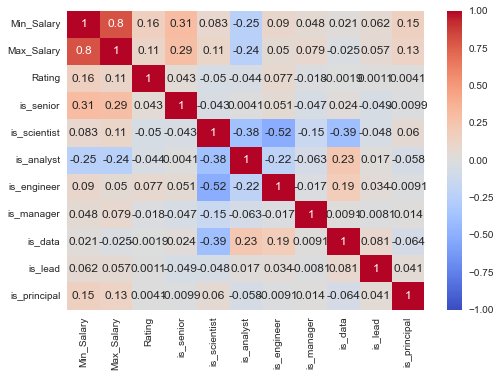

In [17]:
sns.heatmap(data.corr(), 
            cmap="coolwarm", # "coolwarm" and "viridis" are better for color-blindness
            annot = True,
            # Set these two so our color scale reflect the range of correlation values better
            vmax = 1, 
            vmin = -1)
plt.yticks(rotation=0);

In [18]:
# train_dum = pd.concat([X_train_dummies,y_train], axis=1)

In [19]:
# Check correlation with Min_Salary to find interesting variables.
# plt.figure(figsize=(10,12))
# sns.heatmap(train_dum.corr()[['Min_Salary']].sort_values(by='Min_Salary', ascending=False),
#             annot=True)
# plt.title("Top 15 variables with highest correlation with saleprice");

In [20]:
data.groupby(["State", "is_data"]).describe()

Min_Salary                                                 \
                   count      mean      std      min      25%       50%   
State is_data                                                             
CA    False       261.00 108118.72 35382.35 32724.00 83578.00 106610.00   
      True        371.00 105837.53 32511.82 29611.00 82772.00 105899.00   
DC    False        48.00  69732.04 30075.97 21096.00 47423.50  62861.00   
      True        106.00  80366.90 23160.87 36583.00 62318.00  77738.50   
KY    False         1.00  70031.00      NaN 70031.00 70031.00  70031.00   
MD    False       129.00  78030.23 32168.22 20268.00 53639.00  77343.00   
      True         64.00  80060.06 27783.35 27842.00 61989.25  82765.50   
NC    True          1.00  52024.00      NaN 52024.00 52024.00  52024.00   
NJ    False         3.00  44823.67  5501.57 38471.00 43235.50  48000.00   
NY    False        14.00  69504.36 32566.43 20000.00 48471.25  65247.00   
TN    False         1.00  62126.00      NaN 62126.00 62126.00  62126.00   
TX    False       145.00  62730.77 25913.86 24457.00 44998.00  54732.00   
      True        324.00  70679.10 24622.30 19857.00 50950.25  68996.00   
VA    False        51.00  73881.08 24424.50 37254.00 58130.50  70696.00   
      True        272.00  84259.42 20929.39 29516.00 68208.75  83538.00   

                                  Max_Salary            ...            \
                    75%       max      count      mean  ...       75%   
State is_data                                           ...             
CA    False   133572.00 205735.00     261.00 150379.89  ... 174998.00   
      True    123985.00 191071.00     371.00 145702.54  ... 169637.00   
DC    False    92586.00 131982.00      48.00 120596.85  ... 143767.00   
      True     96667.00 131832.00     106.00 119572.36  ... 138898.25   
KY    False    70031.00  70031.00       1.00 139889.00  ... 139889.00   
MD    False    99085.00 152930.00     129.00 121068.69  ... 140626.00   
      True     92566.00 179685.00      64.00 118005.53  ... 135995.00   
NC    True     52024.00  52024.00       1.00  99286.00  ...  99286.00   
NJ    False    48000.00  48000.00       3.00  64335.33  ...  75000.00   
NY    False    89738.00 125410.00      14.00 106951.14  ... 137924.25   
TN    False    62126.00  62126.00       1.00 107781.00  ... 107781.00   
TX    False    76684.00 195818.00     145.00  99785.32  ... 123993.00   
      True     85857.50 162051.00     324.00 105785.11  ... 121232.25   
VA    False    85452.00 141460.00      51.00 119918.80  ... 139234.50   
      True     98291.50 152636.00     272.00 124733.85  ... 141566.75   

                        Rating                                     
                    max  count mean  std  min  25%  50%  75%  max  
State is_data                                                      
CA    False   315439.00 261.00 3.90 0.55 1.30 3.70 3.90 4.10 5.00  
      True    303637.00 371.00 3.94 0.55 2.30 3.60 3.90 4.40 5.00  
DC    False   229990.00  48.00 3.77 0.46 2.50 3.60 3.80 3.90 4.70  
      True    198140.00 106.00 3.73 0.54 2.50 3.20 3.70 4.00 5.00  
KY    False   139889.00   1.00 3.30  NaN 3.30 3.30 3.30 3.30 3.30  
MD    False   294949.00 129.00 3.63 0.52 2.40 3.30 3.79 3.90 4.80  
      True    204079.00  64.00 3.66 0.67 1.90 3.40 3.55 4.00 5.00  
NC    True     99286.00   1.00 3.90  NaN 3.90 3.90 3.90 3.90 3.90  
NJ    False    75000.00   3.00 4.63 0.23 4.50 4.50 4.50 4.70 4.90  
NY    False   212901.00  14.00 3.68 0.57 2.50 3.42 3.79 3.98 4.90  
TN    False   107781.00   1.00 3.30  NaN 3.30 3.30 3.30 3.30 3.30  
TX    False   383416.00 145.00 3.76 0.49 2.20 3.50 3.80 4.00 5.00  
      True    219176.00 324.00 3.69 0.55 1.00 3.40 3.70 4.00 5.00  
VA    False   228925.00  51.00 3.70 0.38 3.00 3.40 3.70 3.95 4.70  
      True    233609.00 272.00 3.74 0.45 2.50 3.40 3.70 3.90 5.00  

[15 rows x 24 columns]

### Baseline Model

In [21]:
data.head()

,Job_title,Company,State,City,Min_Salary,Max_Salary,Job_Desc,Industry,Rating,Date_Posted,Valid_until,Job_Type,is_senior,is_scientist,is_analyst,is_engineer,is_manager,is_data,is_lead,is_principal
0,senior salesforce developer,National Debt Relief,NY,New York,44587,82162,Principle Duties & Responsibilities:\n\nAnalyz...,Finance,4.00,2020-05-08,2020-06-07,FULL_TIME,True,False,False,False,False,False,False,False
1,"deputy executive director, program and legal a...",National Advocates for Pregnant Women,NY,New York,125410,212901,"For FULL Job Announcement, visit our website: ...",Unknown,3.79,2020-04-28,2020-06-07,FULL_TIME,False,False,False,False,False,False,False,False
2,emergency veterinarian - nyc,Veterinary Emergency Group,NY,New York,94715,103279,Emergency VeterinarianThe family you will be j...,Health Care,4.90,2020-05-05,2020-06-07,FULL_TIME,False,False,False,False,False,False,False,False
3,aba therapist,Kids Learning Loft Applied Behavior Analysis S...,NY,Williston Park,20000,35000,Here at Kids Learning Loft Applied Behavior An...,Unknown,3.79,2020-05-07,2020-06-07,PART_TIME,False,False,False,False,False,False,False,False
4,construction project manager,The LiRo Group,NY,Brooklyn,54991,143860,Overview\n\nRanked among the nation's top 10 C...,"Construction, Repair & Maintenance",3.80,2020-05-08,2020-06-07,FULL_TIME,False,False,False,False,True,False,False,False


In [22]:
# X & y
features = ["Rating",
            'is_senior',
            'is_data',
            'is_scientist',
            'is_analyst',
            'is_engineer',
            'is_manager']
# categorical features = ["Company","State","Industry","Job_Type"]

X = data[features]
ymin = data["Min_Salary"]
ymax = data["Max_Salary"]
yavg = (data["Min_Salary"]+data["Max_Salary"])/2

In [23]:
# Let's start with Min prediction
X_train, X_test, y_train, y_test = train_test_split(X,ymin,random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

X_train.index

# Split for y_max
X_train, X_test, y_max_train, y_max_test = train_test_split(X,ymax,random_state=42)

X_train.index

# Split for y_max
X_train, X_test, y_avg_train, y_avg_test = train_test_split(X,yavg,random_state=42)

X_train.index

X_train.head()

,Rating,is_senior,is_data,is_scientist,is_analyst,is_engineer,is_manager
601,3.79,False,True,False,True,False,False
1551,4.00,False,False,True,False,False,False
1219,4.60,False,False,False,False,True,False
704,4.50,False,True,False,True,False,False
586,3.80,False,True,False,True,False,False


In [24]:
# Let's start with Min prediction
X_train, X_test, y_train, y_test = train_test_split(X,ymin,random_state=42)
    
# Split for y_max
X_train, X_test, y_max_train, y_max_test = train_test_split(X,ymax,random_state=42)
    
# Split for y_avg
X_train, X_test, y_avg_train, y_avg_test = train_test_split(X,yavg,random_state=42)


In [25]:
def cal_metrics(model, X_train, X_test, log_y = False):
    """Print model metrics and return regression model
    from given X_train, X_test, and log result,
    it returns R2 and RMSE of y """
    
    if log_y == False:
        y_preds = model.predict(X_train)
        print('Training R2:', metrics.r2_score(y_train, y_preds))
        print('Training RMSE:', metrics.mean_squared_error(y_train, y_preds, squared=False))
        
        y_preds = model.predict(X_test)
        print('Testing R2:', metrics.r2_score(y_test, y_preds))
        print('Testing RMSE:', metrics.mean_squared_error(y_test, y_preds, squared=False))
    
    else:
        y_train_log = np.log(y_train)
        y_test_log = np.log(y_test)
        y_preds = linear.predict(X_train) # Check X_train with dummies
        print('Training R2:', metrics.r2_score(y_train_log, y_preds))
        print('Training RMSE:', metrics.mean_squared_error(np.exp(y_train_log), np.exp(y_preds), squared=False))
        
        y_preds = linear.predict(X_test)
        print('Training R2:', metrics.r2_score(y_test_log, y_preds))
        print('Training RMSE:', metrics.mean_squared_error(np.exp(y_test_log), np.exp(y_preds), squared=False))

In [26]:
linear = LinearRegression()
linear.fit(X_train, y_train)
cal_metrics(linear, X_train, X_test)

Training R2: 0.20063013193594892
Training RMSE: 29021.019000186727
Testing R2: 0.1440627990587805
Testing RMSE: 31194.904269837843


In [27]:
linear.coef_

array([  9205.16666575,  25828.564111  ,   8231.28492138,   9188.93791476,
       -19955.69811549,   4437.96317822,  16509.05949373])

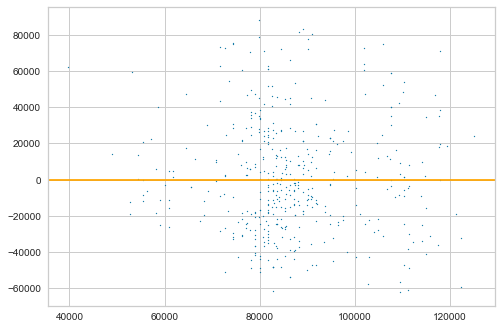

In [28]:
y_preds = linear.predict(X_test)
resids = y_test - y_preds
plt.scatter(y_preds, resids, s=1)
plt.axhline(0, color="orange");

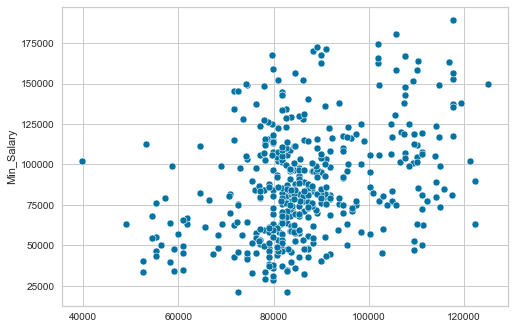

In [29]:
sns.scatterplot(y_preds,y_test);

In [30]:
# lazy = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
# models,predictions = lazy.fit(X_train, X_test, y_train, y_test)

# print(models)

### Model with interaction terms

In [31]:
# Interaction terms for data roles
data["is_data_scientist"] = data["is_data"] * data["is_scientist"]
data["is_data_analyst"] = data["is_data"] * data["is_analyst"]
data["is_data_engineer"] = data["is_data"] * data["is_engineer"]

is_col = data.columns[data.columns.str.contains("is")].to_list()
is_col

features = ["Rating"]
features = ["Rating"] + is_col
X = data[features]
ymin = data["Min_Salary"]
ymax = data["Max_Salary"]
yavg = (data["Min_Salary"]+data["Max_Salary"])/2

In [32]:
data.groupby(["is_data_scientist","is_senior"])["Min_Salary"].describe()

count      mean      std      min      25%  \
is_data_scientist is_senior                                                
False             False     1074.00  77676.02 30725.09 19857.00 52874.00   
                  True       238.00 105654.68 35180.66 37244.00 78087.75   
True              False      396.00  92095.60 26830.01 39825.00 73030.00   
                  True        83.00 114156.17 32740.20 24041.00 92536.50   

                                  50%       75%       max  
is_data_scientist is_senior                                
False             False      74987.50  97949.25 195818.00  
                  True      104135.00 125259.50 205735.00  
True              False      88983.00 110377.00 175846.00  
                  True      112491.00 136866.00 191071.00

In [33]:
features

['Rating',
 'is_senior',
 'is_scientist',
 'is_analyst',
 'is_engineer',
 'is_manager',
 'is_data',
 'is_lead',
 'is_principal',
 'is_data_scientist',
 'is_data_analyst',
 'is_data_engineer']

In [34]:
X

,Rating,is_senior,is_scientist,is_analyst,is_engineer,is_manager,is_data,is_lead,is_principal,is_data_scientist,is_data_analyst,is_data_engineer
0,4.00,True,False,False,False,False,False,False,False,False,False,False
1,3.79,False,False,False,False,False,False,False,False,False,False,False
2,4.90,False,False,False,False,False,False,False,False,False,False,False
3,3.79,False,False,False,False,False,False,False,False,False,False,False
4,3.80,False,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2227,3.70,False,False,False,True,False,True,False,False,False,False,True
2228,3.70,False,False,False,True,False,True,False,False,False,False,True
2229,3.70,False,False,False,True,False,True,False,False,False,False,True
2230,3.70,True,False,False,False,False,True,False,False,False,False,False


In [35]:
# Let's start with Min prediction
X_train, X_test, y_train, y_test = train_test_split(X,ymin,random_state=42)
    
# Split for y_max
X_train, X_test, y_max_train, y_max_test = train_test_split(X,ymax,random_state=42)
    
# Split for y_avg
X_train, X_test, y_avg_train, y_avg_test = train_test_split(X,yavg,random_state=42)


In [36]:
linear = LinearRegression()
linear.fit(X_train, y_train)
cal_metrics(linear, X_train, X_test)

Training R2: 0.25335913856325876
Training RMSE: 28047.531706010894
Testing R2: 0.21134965028445363
Testing RMSE: 29943.665058535527


In [37]:
X_train.shape

(1343, 12)

### Model with categorical variables (Company, State, Job type)

In [38]:
# Company
data["Company"].value_counts()
company_list = data["Company"].value_counts()[:30]
data["Company"] = data["Company"].apply(lambda x : x if x in company_list else "Not enough data")

In [39]:
#data["Company"].value_counts()

In [40]:
# State: Dropping the states where value of number of jobs equal to one as not enough data
index = data[(data['State'] =='NC') | (data['State'] =='TN') | (data['State'] =='KY')].index
data.drop(index , inplace = True)

In [41]:
#data.shape

In [42]:
# data["State"].value_counts()

In [43]:
# City
city_list = data["City"].value_counts()[:25]
data["City"] = data["City"].apply(lambda x : x if x in city_list else "Not enough data")

In [44]:
# Industry
data["Industry"].value_counts()
ind_list = data["Industry"].value_counts()[:17]
ind_list
data["Industry"] = data["Industry"].apply(lambda x : x if x in ind_list else "Not enough data")

In [45]:
data["Industry"].value_counts()

Information Technology          476
Business Services               309
Biotech & Pharmaceuticals       259
Aerospace & Defense             126
Unknown                         115
Finance                          94
Government                       78
Health Care                      78
Education                        53
Manufacturing                    34
Media                            27
Retail                           26
Not enough data                  25
Insurance                        25
Accounting & Legal               25
Oil, Gas, Energy & Utilities     24
Transportation & Logistics        8
Non-Profit                        6
Name: Industry, dtype: int64

In [46]:
jobtype = ["FULL_TIME"]
data["Job_Type"] = data["Job_Type"].apply(lambda x : x if x in jobtype else "PART_TIME")

In [47]:
#data["Job_Type"].value_counts()

In [48]:
# "City"
# features = ["Company","State", "City", "Industry","Job_Type", "Rating"] + is_col

In [49]:
# X & y
is_col = data.columns[data.columns.str.contains("is")].to_list()
features = ["Company", "State", "Industry","Job_Type", "Rating"] + is_col
#features = ["State","Industry","Rating","Job_Type"]

X = data[features]
ymin = data["Min_Salary"]
ymax = data["Max_Salary"]
yavg = (data["Min_Salary"]+data["Max_Salary"])/2

In [50]:
features

['Company',
 'State',
 'Industry',
 'Job_Type',
 'Rating',
 'is_senior',
 'is_scientist',
 'is_analyst',
 'is_engineer',
 'is_manager',
 'is_data',
 'is_lead',
 'is_principal',
 'is_data_scientist',
 'is_data_analyst',
 'is_data_engineer']

In [51]:
X

,Company,State,Industry,Job_Type,Rating,is_senior,is_scientist,is_analyst,is_engineer,is_manager,is_data,is_lead,is_principal,is_data_scientist,is_data_analyst,is_data_engineer
0,Not enough data,NY,Finance,FULL_TIME,4.00,True,False,False,False,False,False,False,False,False,False,False
1,Not enough data,NY,Unknown,FULL_TIME,3.79,False,False,False,False,False,False,False,False,False,False,False
2,Not enough data,NY,Health Care,FULL_TIME,4.90,False,False,False,False,False,False,False,False,False,False,False
3,Not enough data,NY,Unknown,PART_TIME,3.79,False,False,False,False,False,False,False,False,False,False,False
4,Not enough data,NY,Not enough data,FULL_TIME,3.80,False,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,Booz Allen Hamilton,VA,Business Services,FULL_TIME,3.70,False,False,False,True,False,True,False,False,False,False,True
2228,Booz Allen Hamilton,VA,Business Services,FULL_TIME,3.70,False,False,False,True,False,True,False,False,False,False,True
2229,Booz Allen Hamilton,VA,Business Services,FULL_TIME,3.70,False,False,False,True,False,True,False,False,False,False,True
2230,Booz Allen Hamilton,VA,Business Services,FULL_TIME,3.70,True,False,False,False,False,True,False,False,False,False,False


In [52]:
# Drop Industry_Not enough data, Company Not enough data, City Not enough data
# X_dummies = pd.get_dummies(X, columns = ["Company","State",
#                                          "City", "Industry", "Job_Type"])

In [53]:
X_dummies = pd.get_dummies(X, columns = ["Company","State",
                                          "Industry", "Job_Type"])
X_dummies.head()

,Rating,is_senior,is_scientist,is_analyst,is_engineer,is_manager,is_data,is_lead,is_principal,is_data_scientist,...,Industry_Manufacturing,Industry_Media,Industry_Non-Profit,Industry_Not enough data,"Industry_Oil, Gas, Energy & Utilities",Industry_Retail,Industry_Transportation & Logistics,Industry_Unknown,Job_Type_FULL_TIME,Job_Type_PART_TIME
0,4.00,True,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,1,0
1,3.79,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,1,1,0
2,4.90,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,1,0
3,3.79,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,1,0,1
4,3.80,False,False,False,False,True,False,False,False,False,...,0,0,0,1,0,0,0,0,1,0


In [54]:
# Let's start with Min prediction
X_train_dummies, X_test_dummies, y_train, y_test = train_test_split(X_dummies,ymin,random_state=42)
    
# Split for y_max
X_train_dummies, X_test_dummies, y_max_train, y_max_test = train_test_split(X_dummies,ymax,random_state=42)
    
# Split for y_avg
X_train_dummies, X_test_dummies, y_avg_train, y_avg_test = train_test_split(X_dummies,yavg,random_state=42)


In [55]:
X_train_dummies.shape, X_test_dummies.shape, y_train.shape, y_test.shape

((1341, 70), (447, 70), (1341,), (447,))

In [56]:
# Drop Industry_Not enough data, Industry_Unknown
# Company Not enough data, City Not enough data
X_train_dummies.drop(columns = ["Industry_Unknown", "Industry_Not enough data",
                                "Company_Not enough data",#"City_Not enough data",
                                "Job_Type_PART_TIME"],
                     inplace= True)

In [57]:
#X_test = X_test.reindex(columns = X_train.columns, fill_value=0)
X_test_dummies

,Rating,is_senior,is_scientist,is_analyst,is_engineer,is_manager,is_data,is_lead,is_principal,is_data_scientist,...,Industry_Manufacturing,Industry_Media,Industry_Non-Profit,Industry_Not enough data,"Industry_Oil, Gas, Energy & Utilities",Industry_Retail,Industry_Transportation & Logistics,Industry_Unknown,Job_Type_FULL_TIME,Job_Type_PART_TIME
2043,4.00,True,True,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,1,0
1376,3.40,False,False,True,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,1,0
922,3.90,True,False,False,True,False,True,False,False,False,...,0,0,0,0,0,0,0,0,1,0
1793,3.70,False,False,False,True,False,True,False,False,False,...,0,0,0,0,0,0,0,0,1,0
1694,3.50,False,True,False,True,False,True,False,False,True,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640,3.40,False,True,False,False,False,True,False,False,True,...,0,0,0,0,0,0,0,0,1,0
2105,3.30,True,True,False,False,False,False,False,False,False,...,1,0,0,0,0,0,0,0,1,0
1560,4.00,False,True,False,False,False,True,False,False,True,...,0,0,0,0,0,0,0,0,1,0
601,3.79,False,False,True,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,1,0


In [58]:
# Reindex
X_test_dummies = X_test_dummies.reindex(X_train_dummies.columns, axis=1)
X_test_dummies.fillna(0, inplace=True)

In [59]:
X_test_dummies

,Rating,is_senior,is_scientist,is_analyst,is_engineer,is_manager,is_data,is_lead,is_principal,is_data_scientist,...,Industry_Health Care,Industry_Information Technology,Industry_Insurance,Industry_Manufacturing,Industry_Media,Industry_Non-Profit,"Industry_Oil, Gas, Energy & Utilities",Industry_Retail,Industry_Transportation & Logistics,Job_Type_FULL_TIME
2043,4.00,True,True,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1
1376,3.40,False,False,True,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,1
922,3.90,True,False,False,True,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,1
1793,3.70,False,False,False,True,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,1
1694,3.50,False,True,False,True,False,True,False,False,True,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640,3.40,False,True,False,False,False,True,False,False,True,...,0,0,0,0,0,0,0,0,0,1
2105,3.30,True,True,False,False,False,False,False,False,False,...,0,0,0,1,0,0,0,0,0,1
1560,4.00,False,True,False,False,False,True,False,False,True,...,0,0,0,0,0,0,0,0,0,1
601,3.79,False,False,True,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,1


In [60]:
print(X_train_dummies.shape, y_train.shape, 
      X_test_dummies.shape, y_test.shape)

(1341, 66) (1341,) (447, 66) (447,)


In [61]:
X_train_dummies.head()

,Rating,is_senior,is_scientist,is_analyst,is_engineer,is_manager,is_data,is_lead,is_principal,is_data_scientist,...,Industry_Health Care,Industry_Information Technology,Industry_Insurance,Industry_Manufacturing,Industry_Media,Industry_Non-Profit,"Industry_Oil, Gas, Energy & Utilities",Industry_Retail,Industry_Transportation & Logistics,Job_Type_FULL_TIME
2174,3.00,False,False,False,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,1
704,4.50,False,False,True,False,False,True,False,False,False,...,0,1,0,0,0,0,0,0,0,1
586,3.80,False,False,True,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,1
1579,3.90,False,True,False,False,False,True,False,False,True,...,0,0,0,0,0,0,0,0,0,1
1787,3.40,False,True,False,False,False,True,False,False,True,...,0,0,0,0,0,0,0,0,0,1


In [62]:
X_test_dummies

,Rating,is_senior,is_scientist,is_analyst,is_engineer,is_manager,is_data,is_lead,is_principal,is_data_scientist,...,Industry_Health Care,Industry_Information Technology,Industry_Insurance,Industry_Manufacturing,Industry_Media,Industry_Non-Profit,"Industry_Oil, Gas, Energy & Utilities",Industry_Retail,Industry_Transportation & Logistics,Job_Type_FULL_TIME
2043,4.00,True,True,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1
1376,3.40,False,False,True,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,1
922,3.90,True,False,False,True,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,1
1793,3.70,False,False,False,True,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,1
1694,3.50,False,True,False,True,False,True,False,False,True,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640,3.40,False,True,False,False,False,True,False,False,True,...,0,0,0,0,0,0,0,0,0,1
2105,3.30,True,True,False,False,False,False,False,False,False,...,0,0,0,1,0,0,0,0,0,1
1560,4.00,False,True,False,False,False,True,False,False,True,...,0,0,0,0,0,0,0,0,0,1
601,3.79,False,False,True,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,1


In [63]:
X_train_dummies.to_csv("X_train_dummies.csv", sep=",")
X_test_dummies.to_csv("X_test_dummies.csv", sep=",")
y_train.to_csv("y_train.csv", sep=",")
y_test.to_csv("y_test.csv", sep=",")

In [64]:
# lazy = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
# models,predictions = lazy.fit(X_train_dummies, X_test_dummies, y_train, y_test)

# print(models)

In [65]:
linear = LinearRegression()
linear.fit(X_train_dummies, y_train)

LinearRegression()

In [66]:
cal_metrics(linear, X_train_dummies, X_test_dummies)

Training R2: 0.5237433613319699
Training RMSE: 22287.604089877274
Testing R2: 0.47764394187955495
Testing RMSE: 24756.63349628441


In [67]:
# All features
# Training R2: 0.5941701942965956
# Training RMSE: 20976.30326504804
# Testing R2: 0.6041920513152305
# Testing RMSE: 21926.23953550765

# States Only
# Training R2: 0.5637262946938248
# Training RMSE: 21748.860233165826
# Testing R2: 0.5888791918044927
# Testing RMSE: 22346.351600971124

In [68]:
ridge = RidgeCV()

In [69]:
# define model
ridge = RidgeCV(cv = 5)
ridge.fit(X_train_dummies,y_train)

RidgeCV(cv=5)

In [70]:
cal_metrics(ridge, X_train_dummies, X_test_dummies)

Training R2: 0.5224967501584117
Training RMSE: 22316.754149440858
Testing R2: 0.4812838015207753
Testing RMSE: 24670.228643333532


In [71]:
# Training R2: 0.5932816757252666
# Training RMSE: 20999.253334929446
# Testing R2: 0.6036546725325915
# Testing RMSE: 21941.118846789217

# Training R2: 0.5807356356732363
# Training RMSE: 21320.67541558805
# Testing R2: 0.6148960226053767
# Testing RMSE: 21627.7280753403

## Pickle Model

In [219]:
with open('models/author_ridge.pkl', 'wb') as f:
    pickle.dump(ridge, f)

In [221]:
with open('models/author_ridge.pkl', 'rb') as f:
    model = pickle.load(f)

In [222]:
model

RidgeCV(cv=5)

In [72]:
X["State"].value_counts()

CA    632
TX    469
VA    323
MD    193
DC    154
NY     14
NJ      3
Name: State, dtype: int64

In [73]:
X["Industry"].value_counts()

Information Technology          476
Business Services               309
Biotech & Pharmaceuticals       259
Aerospace & Defense             126
Unknown                         115
Finance                          94
Government                       78
Health Care                      78
Education                        53
Manufacturing                    34
Media                            27
Retail                           26
Not enough data                  25
Insurance                        25
Accounting & Legal               25
Oil, Gas, Energy & Utilities     24
Transportation & Logistics        8
Non-Profit                        6
Name: Industry, dtype: int64

In [74]:
X_train_dummies.columns

Index(['Rating', 'is_senior', 'is_scientist', 'is_analyst', 'is_engineer',
       'is_manager', 'is_data', 'is_lead', 'is_principal', 'is_data_scientist',
       'is_data_analyst', 'is_data_engineer', 'Company_Amazon',
       'Company_Amgen', 'Company_Apple',
       'Company_Applied Research Laboratories', 'Company_AstraZeneca',
       'Company_BAE Systems USA', 'Company_Booz Allen Hamilton',
       'Company_Booz Allen Hamilton Inc.', 'Company_Capital One',
       'Company_Facebook', 'Company_Freenome', 'Company_Genentech',
       'Company_Guidehouse', 'Company_LMI', 'Company_Lawrence Berkeley Lab',
       'Company_Leidos', 'Company_Merck KGaA', 'Company_Natera',
       'Company_Navigant Consulting', 'Company_Noblis', 'Company_SAIC',
       'Company_Seen by Indeed', 'Company_Solekai Systems Corp',
       'Company_Southwest Research Institute', 'Company_Stitch Fix',
       'Company_The Aerospace Corporation', 'Company_Tiger Analytics',
       'Company_Twitter', 'Company_UC San Francisco

In [75]:
# define model
lasso = LassoCV(cv = 5)
lasso.fit(X_train_dummies,y_train)

LassoCV(cv=5)

In [76]:
cal_metrics(lasso, X_train_dummies, X_test_dummies)

Training R2: 0.5205621199351351
Training RMSE: 22361.917218298317
Testing R2: 0.4810679126028864
Testing RMSE: 24675.361965683434


In [77]:
# Training R2: 0.5895716576132878
# Training RMSE: 21094.811791696302
# Testing R2: 0.6036039037556444
# Testing RMSE: 21942.524045769165

# Training R2: 0.5593655853656471
# Training RMSE: 21857.283732746393
# Testing R2: 0.5897426383604211
# Testing RMSE: 22322.873074104013

### Robust Outlier Regression

In [78]:
theil = TheilSenRegressor()
theil.fit(X_train_dummies,y_train)

TheilSenRegressor()

In [79]:
cal_metrics(theil, X_train_dummies, X_test_dummies)

Training R2: 0.49601911424571055
Training RMSE: 22927.140689488282
Testing R2: 0.4650141654409301
Testing RMSE: 25054.134860011873


### Random Forest Regressor

In [80]:
rfr = RandomForestRegressor()
rfr.fit(X_train_dummies,y_train)

RandomForestRegressor()

In [81]:
cal_metrics(rfr, X_train_dummies, X_test_dummies)

Training R2: 0.8557926564487792
Training RMSE: 12264.124527884913
Testing R2: 0.4399769378493946
Testing RMSE: 25633.695751274565


In [82]:
# Training R2: 0.8899016345461817
# Training RMSE: 10925.653394446646
# Testing R2: 0.6371232755280124
# Testing RMSE: 20994.302710917244

In [83]:
rfr = RandomForestRegressor()
grid_params = {
    "n_estimators":[100,200,300],
    "max_depth": [5,10],
    "min_samples_split": [2,4],
    "max_features" : ["sqrt", "log2", None],
    "random_state": [42]
}

# Instantiate GridSearchCV.

gs = GridSearchCV(rfr, # what object are we optimizing?
                  param_grid=grid_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [84]:
grid_params

{'n_estimators': [100, 200, 300],
 'max_depth': [5, 10],
 'min_samples_split': [2, 4],
 'max_features': ['sqrt', 'log2', None],
 'random_state': [42]}

In [85]:
starttime = time.time()
gs.fit(X_train_dummies,y_train)
print(f"Runtime: {time.time() - starttime}")

Runtime: 140.44006299972534


In [86]:
gs.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 300,
 'random_state': 42}

In [87]:
gs.best_score_

0.46870523724284235

In [88]:
cal_metrics(gs, X_train_dummies, X_test_dummies)

Training R2: 0.6112478562921823
Training RMSE: 20136.28093315401
Testing R2: 0.4574855610760503
Testing RMSE: 25229.806518925136


### Log transformation

In [89]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [90]:
linear = LinearRegression()
linear.fit(X_train_dummies, y_train_log)

LinearRegression()

In [91]:
cal_metrics(linear, X_train_dummies, X_test_dummies, log_y = True)

Training R2: 0.5030910521692045
Training RMSE: 22541.608588678242
Training R2: 0.45145542704268704
Training RMSE: 25358.8230707829


In [92]:
y_preds = linear.predict(X_test_dummies)

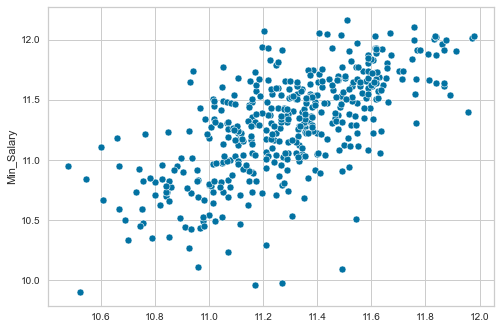

In [93]:
sns.scatterplot(y_preds,y_test_log);

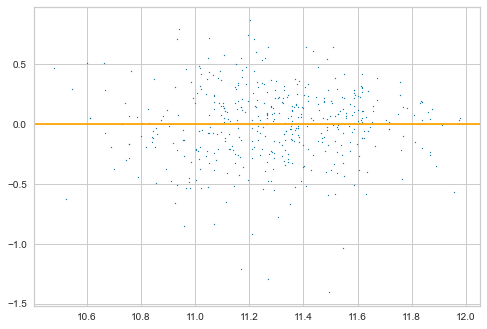

In [94]:
resids = y_test_log - y_preds
plt.scatter(y_preds, resids, s=1)
plt.axhline(0, color="orange");

In [95]:
# data
# 

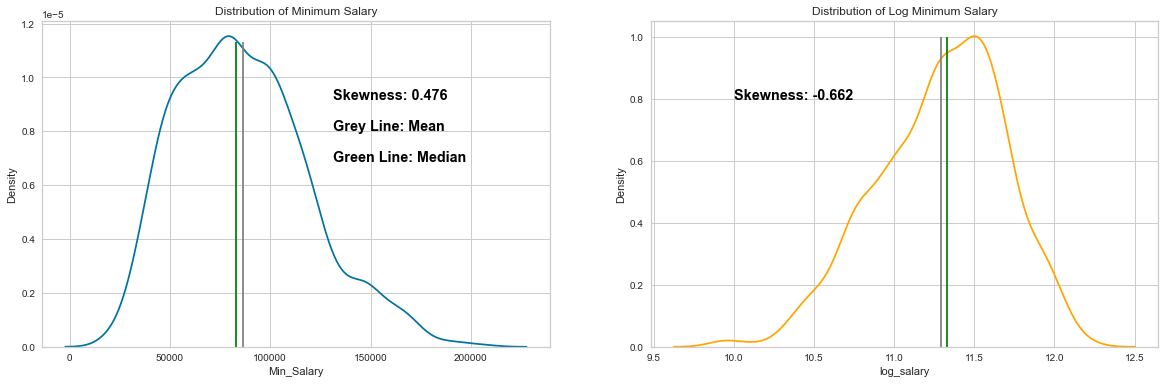

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))
ax1 = sns.kdeplot(ax = axes[0],x = "Min_Salary", data = data)
ax1.vlines(data["Min_Salary"].mean(),ymin = 0, ymax = 0.0000113, color = "grey")
ax1.vlines(data["Min_Salary"].median(),ymin = 0, ymax = 0.0000113, color = "green")
plt.text(7.5, 0.8, "Skewness: 0.476", horizontalalignment='left', size='large', color='black', weight='semibold')
plt.text(7.5, 0.7, "Grey Line: Mean", horizontalalignment='left', size='large', color='black', weight='semibold')
plt.text(7.5, 0.6, "Green Line: Median", horizontalalignment='left', size='large', color='black', weight='semibold')
ax1.title.set_text("Distribution of Minimum Salary")

data['log_salary'] = np.log(data['Min_Salary'])
sns.kdeplot(ax = axes[1],x = "log_salary", data = data, color = "orange")
plt.vlines(data["log_salary"].mean(),ymin = 0, ymax = 1.0, color = "grey")
plt.vlines(data["log_salary"].median(),ymin = 0, ymax = 1.0, color = "green")
plt.text(10, 0.8, "Skewness: -0.662", horizontalalignment='left', size='large', color='black', weight='semibold')
plt.title("Distribution of Log Minimum Salary");

In [97]:
data['Min_Salary'].skew()

0.5450898722722117

In [98]:
data['log_salary'].skew()

-0.4178372732926608

### Neural Net Approach


In [99]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train_dummies)
X_test_sc = sc.transform(X_test_dummies)

In [100]:
X_train

,Rating,is_senior,is_scientist,is_analyst,is_engineer,is_manager,is_data,is_lead,is_principal,is_data_scientist,is_data_analyst,is_data_engineer
601,3.79,False,False,True,False,False,True,False,False,False,True,False
1551,4.00,False,True,False,False,False,False,False,False,False,False,False
1219,4.60,False,False,False,True,False,False,False,False,False,False,False
704,4.50,False,False,True,False,False,True,False,False,False,True,False
586,3.80,False,False,True,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1568,3.90,True,True,False,False,False,True,False,False,True,False,False
1733,3.70,True,True,False,False,False,False,False,False,False,False,False
1298,3.60,False,True,False,False,False,False,False,False,False,False,False
1900,3.90,False,True,False,False,False,False,False,False,False,False,False


In [101]:
X_train_sc.shape

(1341, 66)

In [102]:
# 1. Instantiate Model
model = Sequential()

In [103]:
# Input layer
model.add(Dense(256, input_shape = (91,)))

# Hidden layer
model.add(Dense(128))
model.add(Dropout(0.05))

# Hidden layer
model.add(Dense(128))
model.add(Dropout(0.05))

# Output layer
model.add(Dense(1,activation=None))

In [104]:
# 2. Compile
model.compile(loss="mse", optimizer = "adam", metrics = ["r"])

In [105]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               23552     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 73,089
Trainable params: 73,089
Non-traina

In [106]:
# 3. Fit
history = model.fit(X_train_sc, y_train, epochs=100,
                    batch_size = 64,
                    verbose = 0,
                    validation_data= (X_test_sc, y_test)
                   )

ValueError: in user code:

    File "C:\Users\Tata\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Tata\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Tata\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Tata\anaconda3\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Tata\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Tata\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 91), found shape=(None, 66)


In [ ]:
score = model.evaluate(X_test_sc,
                       y_test,
                       verbose=1)

In [ ]:
base_preds = model.predict(X_test_sc).ravel()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Left plot
ax[0].plot(history.history["loss"], label = "Train") # Training Loss (Blue)
ax[0].plot(history.history["val_loss"], label = "Test") # Testing Loss (Orange)
ax[0].legend();

# y = log loss
# x = epochs

# Right plot
ax[1].plot(history.history["accuracy"], label = "Train") # Training accuracy (Blue)
ax[1].plot(history.history["val_accuracy"], label = "Test") # Testing accuracy (Orange)
ax[1].legend();

# y = accuracy
# x = epochs

### Check Job Description Impact

In [ ]:
## Using skills in JD to predict

In [ ]:
# Skills in Job Describtion(JD)
# Python
data['python_jd'] = data['Job_Desc'].apply(lambda x: 1 if 'python' in x.lower() else 0)

# R studio
data['Rstudio_jd'] = data['Job_Desc'].apply(lambda x: 1 if ('R,' in x or 'R-' in x) else 0)

# Excel
data['excel_jd'] = data['Job_Desc'].apply(lambda x: 1 if 'excel' in x.lower() else 0)

# AWS
data['aws_jd'] = data['Job_Desc'].apply(lambda x: 1 if 'aws' in x.lower() else 0)

# Spark
data['spark_jd'] = data['Job_Desc'].apply(lambda x: 1 if 'spark' in x.lower() else 0)

# Big data
data['big_data_jd'] = data['Job_Desc'].apply(lambda x: 1 if 'big data' in x.lower() else 0)

# Key word:
# Data science
data['data_science_jd'] = data['Job_Desc'].apply(lambda x: 1 if 'data science' in x.lower() else 0)

# Data engineering
data['data_engineer_jd'] = data['Job_Desc'].apply(lambda x: 1 if 'data engineer' in x.lower() else 0)

# Data engineering
data['machine_learning_jd'] = data['Job_Desc'].apply(lambda x: 1 if 'machine learning' in x.lower() else 0)

# Education
data['computer_science_jd'] = data['Job_Desc'].apply(lambda x: 1 if 'computer science' in x.lower() else 0)

# Security Clearance
data['security_clearance_jd'] = data['Job_Desc'].apply(lambda x: 1 if 'security clearance' in x.lower() else 0)

In [ ]:
jd_col = data.columns[data.columns.str.contains("jd")].to_list()
jd_col

In [ ]:
data[jd_col].mean()

In [ ]:
# Let's start with Min prediction
X_train, X_test, y_train, y_test = train_test_split(X,ymin,random_state=42)
    
# Split for y_max
X_train, X_test, y_max_train, y_max_test = train_test_split(X,ymax,random_state=42)
    
# Split for y_avg
X_train, X_test, y_avg_train, y_avg_test = train_test_split(X,yavg,random_state=42)

# Dummies
X_train_dummies = pd.get_dummies(X_train, drop_first=True)
X_test_dummies = pd.get_dummies(X_test)

# Reindex
X_test_dummies = X_test_dummies.reindex(X_train_dummies.columns, axis=1)
X_test_dummies.fillna(0, inplace=True)

In [ ]:
# Check correlation with saleprice to find interesting variables.
plt.figure(figsize=(10,12))
sns.heatmap(data.corr()[['Min_Salary']].sort_values(by='Min_Salary', ascending=False),
            annot=True)
plt.title("Top 15 variables with highest correlation with saleprice");

### Most Common Word in Job Description

In [ ]:
data['Job_Desc'] = data['Job_Desc'].replace('\n\n' , " " , regex = True)
data['Job_Desc'] = data['Job_Desc'].replace('\n' , " " , regex = True)

In [ ]:
cvec = CountVectorizer(stop_words="english", min_df = 0.2)
cvec.fit(data["Job_Desc"])

In [ ]:
# Transforming using our fitted cvec and converting the result to a DataFrame
top_words = pd.DataFrame(cvec.transform(data["Job_Desc"]).todense(),
                       columns=cvec.get_feature_names_out())
top_words.shape

In [ ]:
# Finding the top 100 words that frequently appeared in the job description
jd_top = top_words.sum(axis = 0).sort_values(ascending = False).head(100)
jd_top

In [ ]:
cvec = CountVectorizer(stop_words="english", 
                       min_df = 0.05, #
                       ngram_range = (2,2))
docs = cvec.fit_transform(data["Job_Desc"])

In [ ]:
# plt.figure(figsize=(10,12))
# sns.heatmap(cor.corr()[["Min_Salary"]].sort_values(by="Min_Salary", ascending=False),
#             annot=True)
# plt.title("Top 15 variables with highest correlation with Minimum Salary");

In [ ]:
# Transforming using our fitted cvec and converting the result to a DataFrame
top_word_pairs = pd.DataFrame(cvec.transform(data["Job_Desc"]).todense(),
                       columns=cvec.get_feature_names_out())
top_word_pairs.shape

In [ ]:
vec = CountVectorizer(min_df= 2 , stop_words = 'english' , ngram_range = (2,2))
docs = vec.fit_transform(data.Job_Desc)
features = vec.get_feature_names_out()

visualizer = FreqDistVisualizer(features=features, orient='h' , size = (800,800))
visualizer.fit(docs)
visualizer.show();

In [ ]:
X = data["Job_Desc"]
y = data["Min_Salary"]

In [ ]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. LinearRegression (estimator)

pipe = Pipeline([
    ("cvec", CountVectorizer()), # Transformer (fit, transform)
    ("ridge", Ridge()) # Estimator or model (fit, predict)    
])

In [ ]:
pipe_params = {
    "cvec__max_features":[100,250,500],
    "cvec__min_df": [2,3],
    "cvec__max_df": [0.9,0.95],
    "cvec__ngram_range": [(1,1),(2,2)],
    "cvec__stop_words": ["english"]
}

In [ ]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [ ]:
# Fit GridSearch to training data.
start_time = time.time()
gs.fit(X_train,y_train)
print(f"Runtime:{time.time()-start_time}")

In [ ]:
# What's the best score?
gs.best_score_

In [ ]:
# What's the best params?
gs.best_params_

In [ ]:
# Score model on training set.
print(f"Training score:{gs.score(X_train,y_train)}")

# Score model on testing set.
print(f"Training score:{gs.score(X_test,y_test)}")

# Prediction
preds = gs.predict(X_test)
preds = pd.Series(preds, index = X_test.index,
                  name = "Predictions")

pd.concat([y_test, preds], axis=1)

### Only Data Role

In [ ]:
data_only = data[data["is_data"] == True]
data_only.head()

In [ ]:
data_only.shape

In [ ]:
ProfileReport(
    data_only,
    title="Profile Report for variables"   
)

In [ ]:
# X & y
is_col = data_only.columns[data_only.columns.str.contains("is")].to_list()
features = ["Company","State","City","Industry","Job_Type", "Rating"] + is_col
#features = ["State","Industry","Rating","Job_Type"]

X = data_only[features]
ymin = data_only["Min_Salary"]
ymax = data_only["Max_Salary"]
yavg = (data_only["Min_Salary"]+data_only["Max_Salary"])/2

features

X

# Drop Industry_Not enough data, Company Not enough data, City Not enough data

X_dummies = pd.get_dummies(X, columns = ["Company","State",
                                         "City", "Industry", "Job_Type"])
X_dummies.head()

# Let's start with Min prediction
X_train_dummies, X_test_dummies, y_train, y_test = train_test_split(X_dummies,ymin,random_state=42)
    
# Split for y_max
X_train_dummies, X_test_dummies, y_max_train, y_max_test = train_test_split(X_dummies,ymax,random_state=42)
    
# Split for y_avg
X_train_dummies, X_test_dummies, y_avg_train, y_avg_test = train_test_split(X_dummies,yavg,random_state=42)


X_train_dummies.shape, y_train.shape, X_test_dummies.shape, y_test.shape

# Drop Industry_Not enough data, Industry_Unknown
# Company Not enough data, City Not enough data
X_train_dummies.drop(columns = ["Industry_Unknown", "Industry_Not enough data",
                                "Company_Not enough data","City_Not enough data",
                                "Job_Type_PART_TIME", "is_data"],
                     inplace= True)


#X_test = X_test.reindex(columns = X_train.columns, fill_value=0)

# Reindex
X_test_dummies = X_test_dummies.reindex(X_train_dummies.columns, axis=1)
X_test_dummies.fillna(0, inplace=True)

In [ ]:
lazy = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = lazy.fit(X_train_dummies, X_test_dummies, y_train, y_test)

print(models)

In [ ]:
linear = LinearRegression()
linear.fit(X_train_dummies, y_train)

cal_metrics(linear, X_train_dummies, X_test_dummies)

ridge = RidgeCV()

# define model
ridge = RidgeCV(cv = 5)
ridge.fit(X_train_dummies,y_train)

cal_metrics(ridge, X_train_dummies, X_test_dummies)

# define model
lasso = LassoCV(cv = 5)
lasso.fit(X_train_dummies,y_train)

cal_metrics(lasso, X_train_dummies, X_test_dummies)